In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [87]:
def drop_duplicated_drs(data:pd.DataFrame)-> pd.DataFrame:
    """
    Function to drop duplicated by name and row size
    """
    try:
        data.loc[:,'row_size'] = data.apply(lambda x: x[2:].memory_usage(deep=True), axis=1)
        data.sort_values(by=['name','row_size'], ascending=True, inplace=True)
        data.drop_duplicates(subset=['name'], keep='last', inplace=True)
        return data

    except Exception as e:
        raise e
        
def predict_plan(x:pd.Series) -> str:
    """
    Function to predict which type of plan the Dr. pays for
    """
    result:str = 'Undefined'
    premium:int = x['premium']
    schedule:str = x['schedule']

    if premium == 1:
        result = 'Experto'
    elif premium == 0 and schedule == 'available':
        result = 'Intermedio'
    elif premium == 0 and schedule == 'not available':
        result = 'Básico'
    
    return result

_prices:dict = {
    'Experto':699,
    'Intermedio':499,
    'Básico':299
}
    
def clean_str(x:str) -> str:
    replaces = {
        'á':'a',
        'é':'e',
        'í':'i',
        'ó':'o',
        'ú':'u'
    }
    
    x = str(x)
    x = x.strip().lower()
    
    for r,new in replaces.items():
        x.replace(r,new)
    
    return x
    

def clean_cdmx(data:pd.DataFrame) -> pd.DataFrame:
    
    # clean by regex
    data.loc[data['state_clean'].apply(lambda x: bool(re.match(r'^.*mexico.*|.*méxico.*$|.*ciudad de.*|.*cdmx.*|.*df.*|^.*Federal district.*$|^.*cd mx.*$',x))), 'state_clean'] = 'Ciudad de México'
    
    # clean by concept
    data.loc[data['state']=='yucatán, méxico','state_clean'] = 'Yucatan'
    data.loc[data['state']=='state of mexico','state_clean'] = 'Estado de México'
    data.loc[data['state']=='estado de mexico','state_clean'] = 'Estado de México'
    data.loc[data['state']=='estado de méxico','state_clean'] = 'Estado de México'
    data.loc[data['state']=='edo. de méxico','state_clean'] = 'Estado de México'
    data.loc[data['state']=='edo de mex','state_clean'] = 'Estado de México'
    data.loc[data['state']=='edo.mex','state_clean'] = 'Estado de México'
    data.loc[data['state']=='estado','state_clean'] = 'Estado de México'
    data.loc[data['state']=='distrito nacional','state_clean'] = 'Ciudad de México'
    data.loc[data['state']=='distrito federal','state_clean'] = 'Ciudad de México'
    data.loc[data['state']=='méxcio','state_clean'] = 'Ciudad de México'
    data.loc[data['state']=='región metropolitana','state_clean'] = 'Ciudad de México'
    
    return data


def clean_michoacan(data:pd.DataFrame) -> pd.DataFrame:
    
    # clean by regex
    data.loc[data['state'].apply(lambda x: bool(re.match(r'^.*michoacán.*|.*michoacan.*$|.*mich.*',x))), 'state_clean'] = 'Michoacán'
    
    return data


def clean_queretaro(data:pd.DataFrame) -> pd.DataFrame:
    
    # clean by regex
    data.loc[data['state'].apply(lambda x: bool(re.match(r'^.*queretaro.*|.*querétaro.*$|.*qro.*',x))), 'state_clean'] = 'Querétaro'
    
    return data


def clean_guerrero(data:pd.DataFrame) -> pd.DataFrame:

    # clean by regex
    data.loc[data['state'].apply(lambda x: bool(re.match(r'^.*guerrero.*|.*guer.*$|.*gro.*',x))), 'state_clean'] = 'Guerrero'
    
    return data


def clean_guanajuato(data:pd.DataFrame) -> pd.DataFrame:

    # clean by regex
    data.loc[data['state'].apply(lambda x: bool(re.match(r'^.*guanajuato.*|.*guana.*$|.*gto.*',x))), 'state_clean'] = 'Guanajuato'

    return data
    

def clean_other_states(data:pd.DataFrame) -> pd.DataFrame:
    
    # replace by concept
    replaces:dict = {
        'querétro':'Querétaro',
        'son.':'Sonora',
        'sonorar':'Sonora',
        'jal.':'Jalisco',
        'nuevoleon':'Nuevo León',
        'chih.':'Chihuahua',
        'chih':'Chihuahua',
        'nuevo leson':'Nuevo León',
        'baja califoria':'Baja California'
    }
    
    for old,new in replaces.items():
        data.loc[data['state']==old,'state_clean'] = new
    
    
    return data


In [130]:
states:pd.DataFrame = pd.read_csv('../data/states.csv')
cities:pd.DataFrame = pd.read_csv('../data/first_round/cities.csv')
state_cities:pd.DataFrame = pd.read_csv('../data/first_round/state_cities.csv')    
    
# drop duplicates
states = drop_duplicated_drs(states)
cities = drop_duplicated_drs(cities)
state_cities = drop_duplicated_drs(state_cities)

# add order col
states.insert(0,'order',3)
cities.insert(0,'order',2)
state_cities.insert(0,'order',1)

data = pd.concat([states,cities],axis=0)
data = pd.concat([data,state_cities],axis=0)
data = (
    data
        .sort_values(by=['name','order'])
        .drop_duplicates(subset=['name'], keep='last')
        .reset_index()
)
print(data.shape,' > initial shape')
data['schedule'] = data['schedule'].replace('Not avaialable','not available')
data['schedule'] = data['schedule'].replace('avaialable','available')
data['appointment_price'] = data['appointment_price'].apply(lambda x: str(x).replace(',','').replace('$','') if x is not None else x).astype(float)
data.loc[data['appointment_price']==0,'appointment_price'] = np.nan

# add new columns
data['predicted_plan'] = data.apply(lambda x: predict_plan(x),axis=1)
data['gross'] = data['predicted_plan'].map(_prices)
data['state'] = data['state'].apply(lambda x: clean_str(x))
data['# specialities'] = data['speciality'].apply(lambda x: len(x.split('|')))
data['# services'] = data['services'].apply(lambda x: len(str(x).split('|')) if x is not None else x)
data.loc[data['appointment_price']==1800000,'appointment_price'] = 1800

# cleaning of states
data['state_clean'] = data['state'].copy()
data = clean_cdmx(data=data)
data = clean_michoacan(data=data)
data = clean_queretaro(data=data)
data = clean_guerrero(data=data)
data = clean_guanajuato(data=data)
data = clean_other_states(data=data)
data['state_clean'] = data['state_clean'].apply(lambda x: str(x).capitalize())
data['state_clean'] = data['state_clean'].replace('Estado de méxico','Estado de México')
data['state_clean'] = data['state_clean'].replace('Ciudad de méxico','Ciudad de México')


top_10 = data['state_clean'].value_counts().reset_index().head(10)
other = pd.DataFrame(
        {
        'index':'Otros',
        'state_clean':[data['state_clean'].value_counts().reset_index().iloc[10:]['state_clean'].sum()]
    }
)

central_states:list[str] = [
    'Michoacán',
    'Guanajuato',
    'Guerrero',
    'Querétaro',
    'Estado de México'
]
    
central_states_df = data.loc[
    data['state_clean'].isin([st for st in central_states if st not in list(top_10['index'])]),
    'state_clean'
].value_counts().reset_index()

top_10 = pd.concat([top_10,central_states_df])
top_10 = pd.concat([top_10,other])

data = pd.merge(
    data,
    top_10[['index']],
    left_on = 'state_clean',
    right_on = 'index',
    how='left'
)


data.rename(columns={'index_y':'top10'},inplace=True)
data.to_csv('../data/processed_data.csv',index=False)
print(data.shape,' > final shape')

(5495, 17)  > initial shape
(5495, 23)  > final shape


In [ ]:
# Missing drs
(
    data
        .loc[data['dr_url'].isin(states['dr_url'])==False,['state','dr_url']]
        .rename(columns={'dr_url':'url'})
        .drop_duplicates(subset='url')
        .to_csv('../missing_drs.csv',index=False)
)

# Visualizations

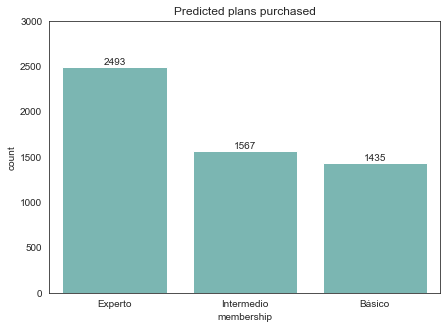

In [372]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
sns.countplot(data,x='predicted_plan', color='#71C0BB')

# Agregar etiquetas encima de cada barra
for p in axes.patches:
    height = p.get_height()
    axes.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.1,                  
        s=int(height),                   
        ha='center',
        va='bottom'
    )
plt.ylim(0,3000)
plt.title('Predicted plans purchased')
plt.xlabel('membership')
plt.ylabel('count')

plt.show()

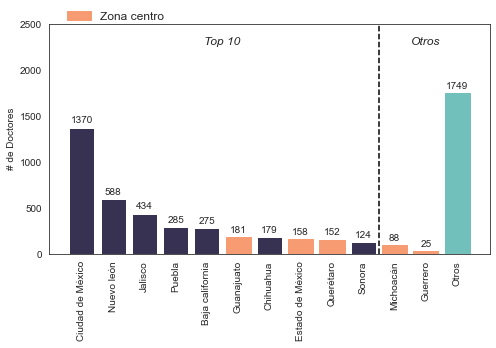

In [156]:
import matplotlib.patches as mpatches

central_states:list[str] = [
    'Michoacán',
    'Guanajuato',
    'Guerrero',
    'Querétaro',
    'Estado de México'
]

sns.set_style('white')
fig, axes = plt.subplots(figsize=(7,5))
sns.barplot(data=top_10,x='index', y='state_clean', color='#332D56')
plt.xticks(rotation=90)
plt.ylim(0,2500)
for i, p in enumerate(axes.patches):
    height = p.get_height()
    axes.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 30,                  
        s=int(height),                   
        ha='center',
        va='bottom'
    )
    if list(top_10['index'])[i] == 'Otros':
        p.set_color('#71C0BB')
        
        
    if list(top_10['index'])[i] in central_states:
        p.set_color('#F79B72')

plt.vlines(x=9.5,ymin=0,ymax=2500,linestyles='--', color='black')
plt.text(
        x=4.5,
        y=2250,                  
        s='Top 10',                   
        ha='center',
        va='bottom',
        fontstyle='italic',
        fontsize=12
    )
plt.text(
        x=11,
        y=2250,                  
        s='Otros',                   
        ha='center',
        va='bottom',
        fontstyle='italic',
        fontsize=12
    )
plt.ylabel('# de Doctores')
plt.xlabel(None)
plt.title(None)
plt.legend(
    bbox_to_anchor=[0.15,1.1],
    frameon=False,
    handles=[
        mpatches.Patch(color='#F79B72', label='Zona centro'),
    ],
    fontsize=12,
    loc='upper center',
    ncol=1
)
plt.tight_layout()
plt.savefig('./barplot_states.png', dpi=400)
plt.show()



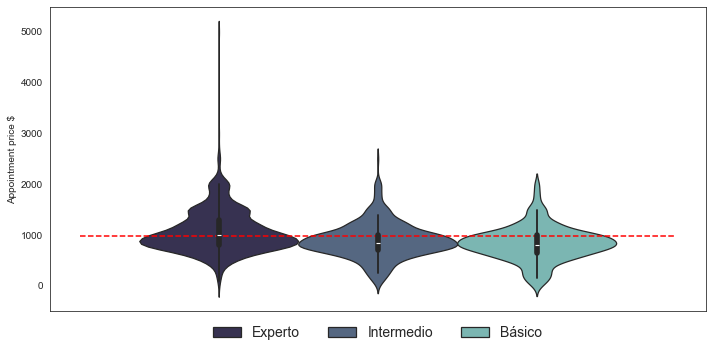

In [633]:
fig,axes = plt.subplots(figsize=(10,5))
sns.violinplot(
    data.loc[(data['appointment_price']>0) & (data['appointment_price']<10000),:],
    y='appointment_price', 
    hue='predicted_plan', 
    palette=['#332D56', '#4E6688', '#71C0BB'],
    hue_order=['Experto','Intermedio','Básico']
)

mean_price = data.loc[(data['appointment_price']>0) & (data['appointment_price']<10000),'appointment_price'].mean()
plt.hlines(y=mean_price,xmin=-0.5, xmax=0.5, color='red', linestyles='--')
plt.title(None)
plt.legend(
    title=None,
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    loc='upper center',
    fontsize=14,
    frameon=False
)
plt.ylabel('Appointment price $')
plt.tight_layout()
plt.show()

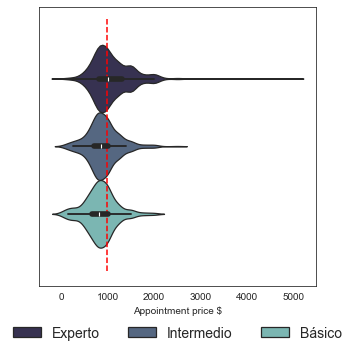

In [644]:
fig,axes = plt.subplots(figsize=(5,5))
sns.violinplot(
    data.loc[(data['appointment_price']>0) & (data['appointment_price']<10000),:],
    x='appointment_price', 
    hue='predicted_plan', 
    palette=['#332D56', '#4E6688', '#71C0BB'],
    hue_order=['Experto','Intermedio','Básico']
)

mean_price = data.loc[(data['appointment_price']>0) & (data['appointment_price']<10000),'appointment_price'].mean()
plt.vlines(x=mean_price,ymin=-0.5, ymax=0.5, color='red', linestyles='--')
plt.title(None)
plt.legend(
    title=None,
    bbox_to_anchor=(0.5,-0.1),
    ncol=3,
    loc='upper center',
    fontsize=14,
    frameon=False
)
plt.xlabel('Appointment price $', y=-0.1)
plt.tight_layout()
plt.savefig('./violin.png', dpi=400)
plt.show()



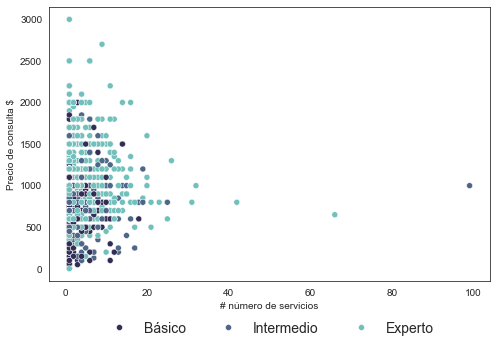

In [785]:
fig,axes = plt.subplots(figsize=(7,5))
plt.tight_layout()
sns.scatterplot(
    data = data.loc[(data['appointment_price']>0) & (data['appointment_price']<5000) & (data['# services']>0),:],
    x = '# services',
    y = 'appointment_price',
    hue = 'predicted_plan',
    palette=['#332D56', '#4E6688', '#71C0BB']
)
plt.xlabel('# número de servicios')
plt.ylabel('Precio de consulta $')
plt.legend(
    bbox_to_anchor=(0.5,-0.1),
    loc='upper center', 
    ncol=3, 
    title=None, 
    frameon=False,
    fontsize=14
)
plt.tight_layout()
plt.savefig('./scatterplot.png',dpi=400)
plt.show()

In [500]:
aux

,predicted_plan,mean,With price,total,Without price
0,Básico,870.258621,348,1435,1087
1,Experto,1076.641550,929,2493,1564
2,Intermedio,897.583149,451,1567,1116


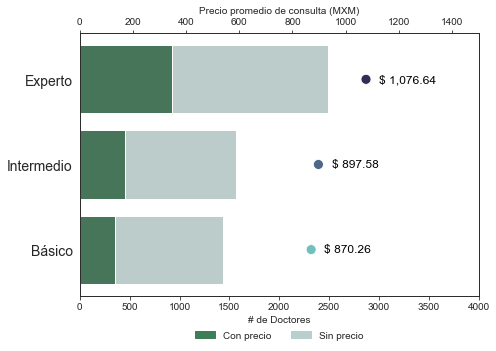

In [660]:
import matplotlib.patches as mpatches

with_price = data.loc[data['appointment_price']>0,:].copy()

aux = with_price.groupby('predicted_plan')['appointment_price'].agg([np.mean, 'count']).reset_index()
all_data = data.groupby('predicted_plan')['name'].agg(['count']).reset_index().rename(columns={'count':'total'})
aux = pd.merge(
    aux,
    all_data,
    on='predicted_plan',
    how = 'left'
)
aux['Without price'] = aux['total'] - aux['count']
aux.rename(columns={'count':'With price'}, inplace=True)
aux.sort_values(by='total',ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    aux,
    x='With price',
    y='predicted_plan',
    color='#3F7D58',
    label='With price'
)
sns.barplot(
    aux,
    x='Without price',
    y='predicted_plan',
    color='#B8CFCE',
    label = 'Without price',
    left=aux['With price']
)

# Configurar eje principal
ax.set_ylabel(None)
ax.set_xlabel('# de Doctores')
ax.set_yticks(range(len(aux['predicted_plan'])))
ax.set_yticklabels(aux['predicted_plan'], fontsize=14)
ax.legend(
    frameon=False,
    ncol=2,
    bbox_to_anchor=(0.5, -0.1),
    loc='upper center',
    handles=[
    mpatches.Patch(color='#3F7D58', label='Con precio'),
    mpatches.Patch(color='#B8CFCE', label='Sin precio')
]
)
ax.set_xlim(0,4000)


# Segundo eje X para el scatterplot
ax2 = ax.twiny()
sns.scatterplot(
    data=aux,
    x='mean',
    y='predicted_plan',
    hue='predicted_plan',
    palette=['#332D56', '#4E6688', '#71C0BB'],
    zorder=20,
    ax=ax2,
    s=100
)

for i in range(len(aux)):
    x_val = aux['mean'].iloc[i]
    y_val = aux['predicted_plan'].iloc[i]
    ax2.text(
        x_val + 50,  # desplazamiento a la derecha del punto
        y_val,
        f"$ {x_val:,.2f}",
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        fontweight='normal',
    )

ax2.set_xlabel('Precio promedio de consulta (MXM)')
ax2.grid(False)
ax2.set_xlim(0,1500)
ax2.legend_.remove()
plt.tight_layout()
plt.savefig('./barplot.png', dpi=400)
plt.show()




In [623]:
with_price['appointment_price'].mean()

988.3449074074074

In [577]:
axes.get_yticklabels()

[Text(0, 0, 'Experto'), Text(0, 1, 'Intermedio'), Text(0, 2, 'Básico')]

In [561]:
for i,y in enumerate(axes.patches):
    print(i,y.get_y())

0 -0.4
1 0.6
2 1.6
3 -0.4
4 0.6
5 1.6


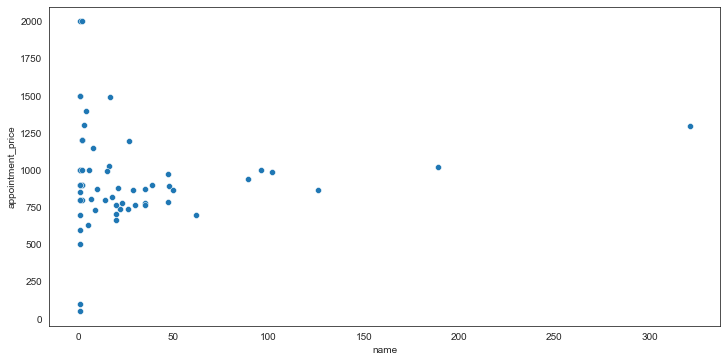

In [392]:
aux_data = data.loc[(data['appointment_price']>0) & (data['appointment_price']<10000),:]
aux_data = aux_data.groupby('state')[['name','appointment_price']].agg({'name':['count'],'appointment_price':['mean']}).reset_index()
aux_data.columns = [ col[0] for col in aux_data.columns]

fig,axes = plt.subplots(figsize=(10,5))
plt.tight_layout()
sns.scatterplot(
    data = aux_data,
    x = 'name',
    y = 'appointment_price'
)
plt.show()

In [405]:
data.loc[data.loc[data['appointment_price']<5000,'appointment_price'].idxmax()]

index                                                                                                                                14441
order                                                                                                                                    3
url                                                                               https://directorio.eleonor.mx/directory/e/ciudad-de/i/19
state                                                                                                                            Ciudad de
name                                                                                                         Dr. Eduardo Rafael Bucio Reta
premium                                                                                                                                  1
speciality                                       Especialidad: Medicina Interna Cédula: 327786 | Especialidad: Cardiología Cédula: 4371605
schedule                   

In [417]:
data['name'] = data['name'].apply(lambda x: clean_str(x) if x is not None else x)

SyntaxError: unexpected EOF while parsing (78984121.py, line 3)

In [450]:
data[data['state'].apply(lambda x: bool(re.match('^.*uruap.*$',str(x)))==True)]

,index,order,url,state,name,premium,speciality,schedule,videocall,videocall_price,principal_caresite,other_caresite,appointment_price,services,dr_url,phone_number,row_size,predicted_plan,gross,# specialities,# services


In [447]:
data['state']

0                  nuevoleon
1                  ciudad de
2                  nuevoleon
3                  de mexico
4                  araucanía
                ...         
5490                  berlin
5491               de mexico
5492    coahuila de zaragoza
5493               chihuahua
5494                 jalisco
Name: state, Length: 5495, dtype: object

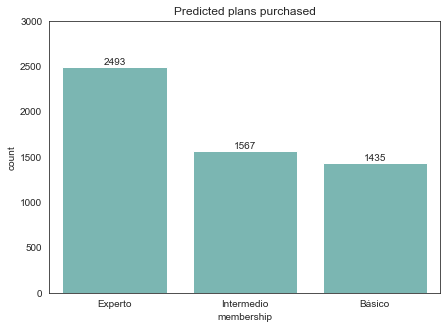

In [371]:
fig, axes = plt.subplots(1,1,figsize=(7,5))
sns.countplot(data,x='predicted_plan', color='#71C0BB')

# Agregar etiquetas encima de cada barra
for p in axes.patches:
    height = p.get_height()
    axes.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.1,                  
        s=int(height),                   
        ha='center',
        va='bottom'
    )
plt.ylim(0,3000)
plt.title('Predicted plans purchased')
plt.xlabel('membership')
plt.ylabel('count')

plt.show()

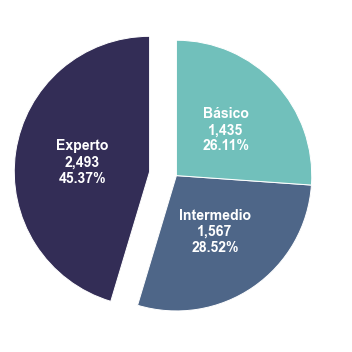

In [705]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect='equal'))

# Procesar datos
aux_data = data['predicted_plan'].value_counts().reset_index().sort_values(by='predicted_plan', ascending=False)
valores = aux_data['predicted_plan']
etiquetas = aux_data['index']

# Función para combinar label y porcentaje con salto de línea
def combinar_label_pct(pct, allvals):
    total = sum(allvals)
    idx = combinar_label_pct.idx
    label = etiquetas.iloc[idx]
    value = valores.iloc[idx]
    combinar_label_pct.idx += 1
    return f'{label}\n{value:,.0f}\n{pct:.2f}%'

# Inicializar índice
combinar_label_pct.idx = 0

# Crear gráfico
wedges, texts, autotexts = plt.pie(
    x=valores,
    labels=None,  # Usamos etiquetas dentro de autopct
    explode=[0.2, 0, 0],
    colors=['#332D56', '#4E6688', '#71C0BB'],
    autopct=lambda pct: combinar_label_pct(pct, valores),
    pctdistance=0.5,
    labeldistance=1.1,
    startangle=90
)

# Estilo de los textos de porcentaje + etiqueta
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

plt.title('')
plt.tight_layout()
plt.savefig('./pie_plot.png', dpi=400)
plt.show()

In [751]:
aux['gross'].sum()

2953605

In [158]:
pivot_df.loc[['Experto', 'Intermedio', 'Básico']]

top10,Baja california,Chihuahua,Ciudad de México,Estado de México,Guanajuato,Guerrero,Jalisco,Michoacán,Nuevo león,Otros,Puebla,Querétaro,Sonora
predicted_plan,,,,,,,,,,,,,
Experto,88773,65706,508173,27261,51027,4194,146790,22368,201312,457146,87375,40542,41940
Intermedio,39421,23453,174151,18962,25948,6487,54890,16467,88323,260977,36427,20958,15469
Básico,20631,11362,87906,24219,16744,1794,34086,6877,36777,137241,26013,15548,9867


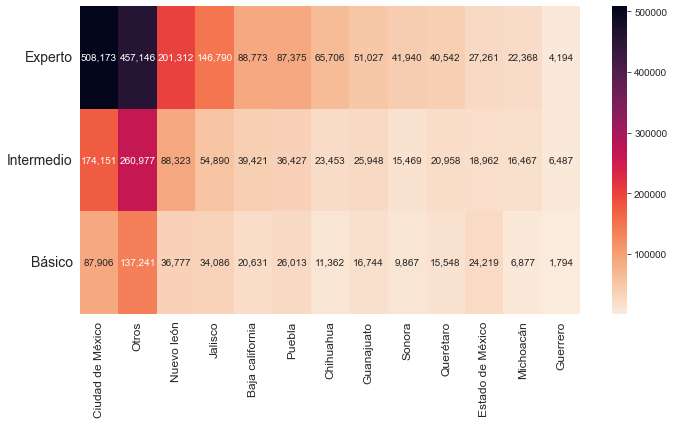

In [166]:
data['top10'] = data['top10'].fillna('Otros')
aux = data.groupby(['top10','predicted_plan'])['gross'].sum().reset_index()
aux.sort_values(by='gross', inplace=True, ascending=False)
order_cols = list(aux['top10'].unique())
pivot_df = aux.pivot(index='predicted_plan', columns='top10', values='gross')
pivot_df = pivot_df.loc[['Experto', 'Intermedio', 'Básico'], order_cols]

# Crear el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_df,
    annot=True,          
    fmt=',',
    cmap='rocket_r',
    linecolor='white'
)
plt.title(None)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.savefig('./heatmap.png', dpi=400)
plt.show()

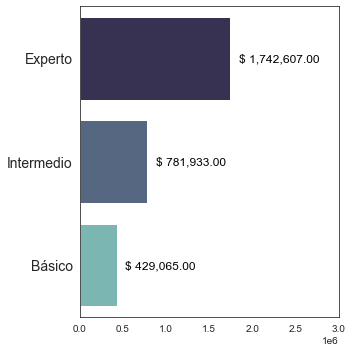

In [774]:
aux = data.groupby(['predicted_plan'])['gross'].sum().reset_index()
aux = aux.sort_values(by='gross', ascending=False)

# Crear el heatmap
fig, axes = plt.subplots(figsize=(5, 5))
sns.barplot(
    aux,
    y='predicted_plan',
    x='gross',
    hue='predicted_plan',
    palette=['#332D56', '#4E6688', '#71C0BB']
)
plt.title(None)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(np.arange(0,3000001,500000))
plt.xlim(0,3000001)
plt.yticks(fontsize=14)

for i in range(len(aux)):
    x_val = aux['gross'].iloc[i]
    y_val = aux['predicted_plan'].iloc[i]
    axes.text(
        x_val + 100000,  # desplazamiento a la derecha del punto
        y_val,
        f"$ {x_val:,.2f}",
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        fontweight='normal'
    )


plt.tight_layout()
plt.savefig('./bar_earnings.png', dpi=400)
plt.show()